<a href="https://colab.research.google.com/github/4ci1ab/NH704F/blob/main/Traj_Vis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library

In [174]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import os
import pandas as pd

import math as mt
from tabulate import tabulate as tb
from IPython.display import display

import scipy.constants as sc
from scipy import constants

### Constants

In [175]:
qe = sc.elementary_charge
me = sc.electron_mass
mRb = ((85*10**-3)/(602*10**21))
qRb = 1.602176634*10**-19
rho = (10**1)*qe #Columb/m -> eq
s_w = 0.01*1e-3 #mm
scyl = 1e-1 #(m)

In [176]:
Rwire = 15e-6  # Radius of wire
r_min = Rwire  # Minimum distance to wire

min_time_step = 1e-10
max_time_step = 100e-9

### Fund. Funcs.


In [177]:
def E_fd(s):
  (rho)/(2*(mt.pi)*(sc.epsilon_0)*(s))
  return (rho)/(2*(mt.pi)*(sc.epsilon_0)*(s))

def Phi_fd(s):
  ((rho)* mt.log(s/scyl))/(2*(mt.pi)*(sc.epsilon_0))

def U_fd(s):
  qRb * Phi_fd(s)

def K_pr(s):
  U_fd(Rwire)-U_fd(s)

def K_exp(vx0,vy0):
  (0.5)*(mRb)*((vx0**2)+(vy0**2))

In [178]:
def Acc(s):
  F_s = qRb * E_fd(s)
  a_fd = F_s/mRb
  return a_fd

In [179]:
def scaled_timestep_conserve_energy(distance_to_wire, r_max):
    # Find k from sublevel
    # k = sublevel - 315

    # Calculate a normalized distance factor with log scale
    normalized_distance = max(0, min(np.log10(distance_to_wire - r_min + 1) / np.log10(r_max - r_min + 1), 1))

    # Define a scaling function based on normalized distance and k
    scaling_factor = min_time_step + normalized_distance * (max_time_step - min_time_step)

    # Adjust the scaling factor based on the state (k)
    # scaling_factor /= abs(k - 32) + 1  # Adding 1 to avoid division by zero

    # Ensure the time step stays within the specified range
    scaled_step = max(min(scaling_factor, max_time_step), min_time_step)

    return scaled_step

In [180]:
def scaled_timestep(distance_to_wire, r_max):
    # Find k from sublevel
    # k = sublevel - 315

    # Calculate a normalized distance factor
    normalized_distance = max(0, min((distance_to_wire - r_min) / (r_max - r_min), 1))

    # Define a scaling function based on normalized distance and k
    scaling_factor = min_time_step + normalized_distance * (max_time_step - min_time_step)

    # Adjust the scaling factor based on the state (k) with a logarithmic scale
    # scaling_factor /= np.log10(abs(k - 32) + 1)  # Adding 1 to avoid log(0)

    # Ensure the time step stays within the specified range
    scaled_step = max(min(scaling_factor, max_time_step), min_time_step)

    return scaled_step

In [181]:
def iterative_dynamics(t0, x0, vx0, y0, vy0, delta_t0):
    # Define constants
    #sThresh1 = 20 * Rwire  # Distance threshold (used to change step size once we are closer to wire)
    g = - 9.81  # Gravitational acceleration

    s0 = ((x0**2 + y0**2)**0.5)

    # Calculate the time step based on s0
    delta_t = delta_t0 #scaled_timestep(s0, 0.001)

    a0 = Acc(s0) #+ g

    # Calculate acceleration components
    ax0 = (a0 * x0) / s0
    ay0 = (a0 * y0) / s0

    # Update time and position
    t1 = t0 + delta_t
    x1 = x0 + vx0 * delta_t + (ax0 * delta_t**2) / 2
    vx1 = vx0 + ax0 * delta_t
    y1 = y0 + vy0 * delta_t + (ay0 * delta_t**2) / 2
    vy1 = vy0 + ay0 * delta_t

    # Calculate the new distance from the origin
    s1 = ((x1**2 + y1**2)**0.5)

    # Calculate the new acceleration
    a1 = Acc(s1) #+ g

    # Update the time step based on s1
    delta_t = scaled_timestep(s1, 0.001)

    # Return the updated values
    return t1, x1, vx1, y1, vy1, a1, delta_t

In [182]:
def iterative_dynamics_for_energy(t0, x0, vx0, y0, vy0, delta_t0):
    # Define constants
    #sThresh1 = 20 * Rwire  # Distance threshold (used to change step size once we are closer to wire)
    g = - 9.81  # Gravitational acceleration

    s0 = ((x0**2 + y0**2)**0.5)

    # Calculate the time step based on s0
    delta_t = scaled_timestep_conserve_energy(s0, 0.001)

    a0 = Acc(s0) #+ g

    # Calculate acceleration components
    ax0 = (a0 * x0) / s0
    ay0 = (a0 * y0) / s0

    # Update time and position
    t1 = t0 + delta_t
    x1 = x0 + vx0 * delta_t + (ax0 * delta_t**2) / 2
    vx1 = vx0 + ax0 * delta_t
    y1 = y0 + vy0 * delta_t + (ay0 * delta_t**2) / 2
    vy1 = vy0 + ay0 * delta_t

    # Calculate the new distance from the origin
    s1 = ((x1**2 + y1**2)**0.5)

    # Calculate the new acceleration
    a1 = Acc(s1) #+ g

    # Update the time step based on s1
    delta_t = scaled_timestep_conserve_energy(s1, 0.001)

    # Return the updated values
    return t1, x1, vx1, y1, vy1, a1, delta_t

In [183]:
def perform_iterations_w_energy(initial_conditions):

     # Unpack initial conditions
    t0, x0, vx0, y0, vy0, delta_t0 = initial_conditions

    t = 0   #initialize time
    Rwire = 15e-6  # (m) initialize min distance from origin
    collision_indicator = 0 # binary variable to store if atom hits wire

    # Create a list to store position values
    trajectory = []

    # Append the current position (x0, y0) to the trajectory list
    trajectory.append([x0, y0])

    # Create energy DataFrame for later use
    energy_df = pd.DataFrame(columns=["Time", "Distance from Wire", "Kinetic Energy", "Potential Energy", "Total Energy", "% of Starting Energy"])

    #Calculate initial energy values
    s0 = ((x0**2 + y0**2)**0.5)
    initial_potential_energy = U_fd(s0)
    initial_kinetic_energy = 0.5 * mRb * (vx0**2 + vy0**2)
    initial_total_energy = initial_kinetic_energy + initial_potential_energy

    #Use list to store energy values
    initial_row = {"Time": 0, "Distance from Wire": s0 - Rwire, "Kinetic Energy": initial_kinetic_energy, "Potential Energy": initial_potential_energy, "Total Energy": initial_total_energy, "% of Starting Energy":1}
    row_list = [initial_row]

    # Calculate tLimit based on the Interaction type          #Stop when it passes plot limits
    # if sublevel < 300:
    #     tLimit = (abs(y0) / vy0) * 1.2
    # else:
      #  tLimit = (abs(y0) / vy0) * 2

    tLimit = (abs(y0) / vy0) * 1.2   #use shorter time for 'TEST'

    while t < tLimit:

        t, x, vx, y, vy, a, delta_t = iterative_dynamics_for_energy(t0, x0, vx0, y0, vy0, delta_t0)

        #Add new position values to list
        trajectory.append([x, y])

        # Calculate energy values
        kinetic_energy = 0.5 * mRb * (vx**2 + vy**2)
        s1 = ((x**2 + y**2)**0.5)
        potential_energy = U_fd(s1)
        total_energy = kinetic_energy + potential_energy
        energy_loss = total_energy/initial_total_energy
        # Store the energy values as a dictionary
        row = {"Time": t, "Distance from Wire": s1 - Rwire, "Kinetic Energy": kinetic_energy, "Potential Energy": potential_energy, "Total Energy": total_energy, "% of Starting Energy":energy_loss}

        # Add the row to the list
        row_list.append(row)

        #Set new conditions as initial conditions for next iteration
        t0, x0, vx0, y0, vy0, a0, delta_t0 = t, x, vx, y, vy, a, delta_t

        if s1 <= Rwire:
            row_list.pop()
            collision_indicator = 1
            t = tLimit

    # Extract x and y values from the trajectories
    x_values, y_values = zip(*trajectory)

    # Concatenate the list of rows into the DataFrame
    energy_df = pd.concat([pd.DataFrame(row_list)], ignore_index=True)

    return x_values, y_values, energy_df, collision_indicator

In [184]:
def perform_iterations_wout_energy(initial_conditions):

     # Unpack initial conditions
    t0, x0, vx0, y0, vy0, delta_t0 = initial_conditions

    t = 0   #initialize time
    Rwire = 15e-6  # (m) initialize min distance from origin
    collision_indicator = 0 # binary variable to store if atom hits wire

    # Create a list to store position values
    trajectory = []

    # Append the current position (x0, y0) to the trajectory list
    trajectory.append([x0, y0])

    #Calculate initial position
    s0 = ((x0**2 + y0**2)**0.5)

    tLimit = (abs(y0) / vy0) * 1.5   #use shorter time for 'TEST'

    while t < tLimit:

        t, x, vx, y, vy, a, delta_t = iterative_dynamics(t0, x0, vx0, y0, vy0, delta_t0)

        #Add new position values to list
        trajectory.append([x, y])

        # Calculate new position
        s1 = ((x**2 + y**2)**0.5)

        #Set new conditions as initial conditions for next iteration
        t0, x0, vx0, y0, vy0, a0, delta_t0 = t, x, vx, y, vy, a, delta_t

        if s1 <= Rwire:
            collision_indicator = 1
            t = tLimit

    # Extract x and y values from the trajectories
    x_values, y_values = zip(*trajectory)

    return x_values, y_values, collision_indicator


### Single Atom

 Int Cond

In [185]:
#Initial conditions
x0 = 0.001
t0 = 0
y0 = - 0.001  # (m)
vx0 = 0  # (m/s)
vy0 = 1  # (m/s)

delta_t0 = 1e-7 #Initial placeholder value

In [186]:
print("{:.2e}".format((abs(y0) / vy0) * 1.5))

1.50e-03


In [187]:
# #Time Step
# delT = delta_t0
# tstep = 1e-8
# Tint = list(np.arange(0, delT, tstep))
# steps = 1
Tint = range(3)

In [188]:
# #generate trajectory and energy data
# sublevels = [284, 300, 314, 320]
# trajectory = {}
# for sublevel in sublevels:
#     initial_conditions = t0, x0, vx0, y0, vy0, delta_t0
#     trajectory[sublevel] = perform_iterations_wout_energy(initial_conditions)

In [189]:
# sublevels = [284, 300, 314, 320]
trajectory = {}
for ti in Tint:
    initial_conditions = t0, x0, vx0, y0, vy0, delta_t0
    trajectory[ti] = perform_iterations_wout_energy(initial_conditions)

In [190]:
initial_conditions = t0, x0, vx0, y0, vy0, delta_t0

print(perform_iterations_wout_energy(initial_conditions)[0][1])
print(perform_iterations_wout_energy(initial_conditions)[1][1])

0.0010000000000816977
-0.0009999000000816976


In [191]:
# print(trajectory[0][1])

In [192]:
print("{:.2e}".format(((x0**2 + y0**2)**0.5)))

1.41e-03


Plt Data

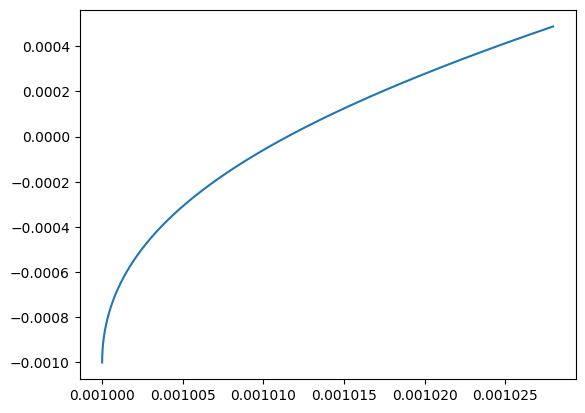

In [193]:
plt.plot(perform_iterations_wout_energy(initial_conditions)[0], perform_iterations_wout_energy(initial_conditions)[1])

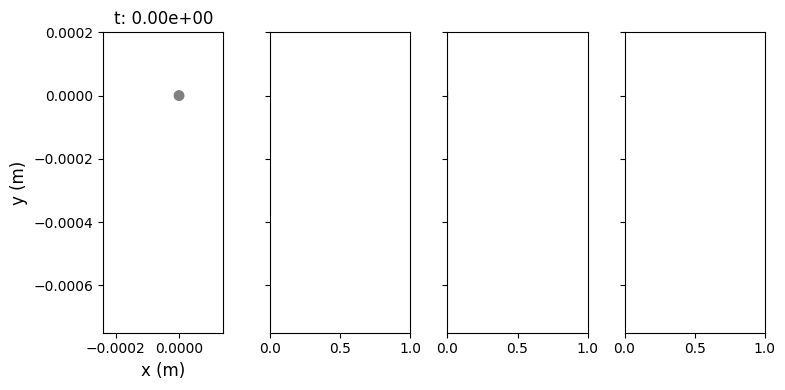

In [194]:
# Create a single row of four subplots with adjusted spacing
fig, axs = plt.subplots(1, 4, figsize=(8, 4), sharey = True)  # Use sharex to share x-axis ticks

# Add the permanent marker
Rwire = 15e-6  # Radius of the wire
x_center = 0  # X-coordinate of the center of the wire
y_center = 0  # Y-coordinate of the center of the wire

#Plot ranges
xMin, xMax = -0.00024, 0.00014
yMin, yMax = -0.00075, 0.0002
xTicks = [-0.0002, -0.0001, 0, 0.0001, 0.0002]  # Define your desired tick positions

# Plot the wire as a circle
for ax in axs:
    circle = plt.Circle((x_center, y_center), Rwire, color='grey', fill=True)
    ax.add_artist(circle)

# Plot the trajectories for each sublevel in a separate subplot
for i, ti in enumerate(Tint[::len(axs)]): #I dont think it includes end point
#   k = sublevel - 315
    ax = axs[i]
    ax.plot(trajectory[0][0], trajectory[0][1], color='blue', linestyle='dashed', linewidth=1)
    ax.set_xlabel('x (m)', fontsize=12)
    if i == 0:
        ax.set_ylabel('y (m)', fontsize=12)
    ax.set_title(f't: {"{:.2e}".format(ti)}', fontsize=12)
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)
    ax.set_aspect('equal')


# # Set the x-ticks for the entire row of subplots
# for i in range(4):
#     plt.sca(axs[i])
#     plt.xticks(xTicks, rotation=45)  # Set x ticks for the bottom subplot


plt.tight_layout()
plt.show()

NameError: name 'sublevels' is not defined

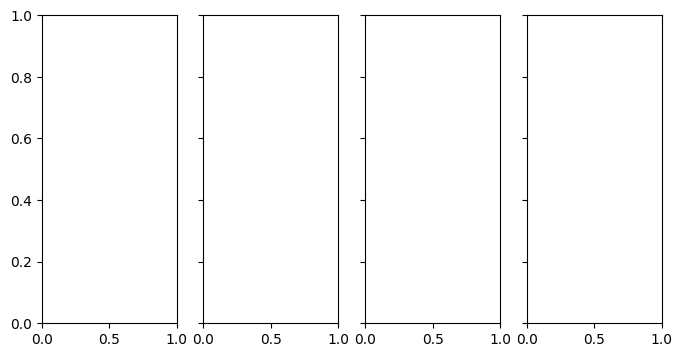

In [195]:
# Create a single row of four subplots with adjusted spacing
fig, axs = plt.subplots(1, 4, figsize=(8, 4), sharey=True)  # Use sharex to share x-axis ticks

# Add the permanent marker
Rwire = 15e-6  # Radius of the wire
x_center = 0  # X-coordinate of the center of the wire
y_center = 0  # Y-coordinate of the center of the wire

# Plot ranges
xMin, xMax = -0.00024, 0.00014
yMin, yMax = -0.00075, 0.0002
xTicks = [-0.0002, -0.0001, 0, 0.0001, 0.0002]  # Define your desired tick positions

# Plot the wire as a circle
for ax in axs:
    circle = plt.Circle((x_center, y_center), Rwire, color='grey', fill=True)
    ax.add_artist(circle)

# Plot the trajectories for each sublevel in a separate subplot
for i, sublevel in enumerate(sublevels):
    k = sublevel - 315
    ax = axs[i]
    ax.plot(trajectory[sublevel][0], trajectory[sublevel][1], color='blue', linestyle='dashed', linewidth=1)
    ax.set_xlabel('x (μm)', fontsize=12)
    if i == 0:
        ax.set_ylabel('y (μm)', fontsize=12)
    ax.set_title(f'k: {k}', fontsize=12)
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)
    ax.set_aspect('equal')

# Convert axis labels to micrometers
for ax in axs:
    x_ticks = ax.get_xticks() * 1e6
    y_ticks = ax.get_yticks() * 1e6

ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks])
ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks])

# Set the x-ticks for the entire row of subplots
for i in range(4):
    plt.sca(axs[i])
    plt.xticks(xTicks, rotation=45)  # Set x ticks for the bottom subplot

plt.tight_layout()
plt.show()